# Trading Strategies powered by Machine Learning - Support Vector Classifier


## Import all of the packages

In [2]:
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from talib import MA_Type
import talib as ta
from bs4 import BeautifulSoup
import datetime
import json
import numpy as np
import pandas as pd
import requests
import time
import warnings
warnings.simplefilter('ignore')

### Download data 

In [3]:
import sys
sys.path.append('../../')

In [4]:
from util.load_data import *
from config.constants import *

In [5]:
XAUUSD = load_data()

In [6]:
XAUUSD['D1']

,Open,High,Low,Close,Volume
Time,,,,,
2007-01-01,635.679,637.103,635.006,635.943,604
2007-01-02,635.791,640.802,635.286,639.143,1282
2007-01-03,639.029,644.663,624.634,626.602,1302
2007-01-04,626.699,630.352,619.600,622.533,1365
2007-01-05,622.268,625.768,601.591,606.841,1284
...,...,...,...,...,...
2023-03-06,1852.255,1858.168,1845.015,1846.255,1380
2023-03-07,1846.225,1851.555,1812.655,1813.865,1380
2023-03-08,1813.855,1824.185,1809.248,1815.175,1379


## Create the features for model with technical analysis

In [7]:
data = XAUUSD['D1'].copy()

In [8]:
data['High Shifted']=data['High'].shift(1)
data['Low Shifted'] = data['Low'].shift(1)
data['Close Shifted'] = data['Close'].shift(1)
    
data['Upper BBand'], data['Middle BBand'],data['Lower BBand']= ta.BBANDS(data['Close Shifted'],timeperiod=20,)
    
data['RSI'] = ta.RSI(np.array(data['Close Shifted']), timeperiod=14)

data['Macd'], data['Macd Signal'],data['Macd Hist'] = ta.MACD(data['Close Shifted'], fastperiod=12, slowperiod=26, signalperiod=9)

data['Momentum'] = ta.MOM(data['Close Shifted'],timeperiod=12)
    
data['Returns'] = np.log(data['Open']/data['Open'].shift(1)) 


In [9]:
data

,Open,High,Low,Close,Volume,High Shifted,Low Shifted,Close Shifted,Upper BBand,Middle BBand,Lower BBand,RSI,Macd,Macd Signal,Macd Hist,Momentum,Returns
Time,,,,,,,,,,,,,,,,,
2007-01-01,635.679,637.103,635.006,635.943,604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-02,635.791,640.802,635.286,639.143,1282,637.103,635.006,635.943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000176
2007-01-03,639.029,644.663,624.634,626.602,1302,640.802,635.286,639.143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005080
2007-01-04,626.699,630.352,619.600,622.533,1365,644.663,624.634,626.602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.019483
2007-01-05,622.268,625.768,601.591,606.841,1284,630.352,619.600,622.533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-06,1852.255,1858.168,1845.015,1846.255,1380,1855.314,1852.125,1852.255,1869.207196,1837.99610,1806.785004,51.870764,-9.240554,-13.537721,4.297167,13.66,-0.001289
2023-03-07,1846.225,1851.555,1812.655,1813.865,1380,1858.168,1845.015,1846.255,1866.087303,1837.07395,1808.060597,49.002419,-7.948326,-12.419842,4.471516,4.58,-0.003261
2023-03-08,1813.855,1824.185,1809.248,1815.175,1379,1851.555,1812.655,1813.865,1862.841223,1834.63730,1806.433377,37.081483,-9.429135,-11.821701,2.392565,-21.57,-0.017689


### Add the signal

In [10]:
data['Signal'] = np.where((data['Returns'] > 0),1,-1)

## Training the Model

In [11]:
max_abs_scaler = preprocessing.MaxAbsScaler()

data.dropna(inplace=True)

X = np.array(data.drop(['Signal', 'Returns'], 1))
X = max_abs_scaler.fit_transform(X)
Y = np.array(data['Signal'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)


model = svm.SVC(kernel='rbf', decision_function_shape='ovo')
# model = svm.SVC(kernel='linear')
# model = svm.SVC(kernel='linear',decision_function_shape='ovo')
# model = svm.SVC(kernel='rbf',decision_function_shape='ovo')
# model = svm.SVC(kernel='poly')
# model = svm.SVC(kernel='poly',decision_function_shape='ovo')
# model = svm.SVC(kernel='sigmoid')
# model = svm.SVC(kernel='sigmoid',decision_function_shape='ovo')

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(
    y_test, y_pred, pos_label=str(1), average="macro")
Recall = metrics.recall_score(
    y_test, y_pred, pos_label=str(1), average="macro")

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred,pos_label=str(1),average="macro"))

print("Recall:",metrics.recall_score(y_test, y_pred,pos_label=str(1),average="macro"))

Accuracy: 0.7132401862940785
Precision: 0.7148511046716874
Recall: 0.7078091488203848


## Portfolio performance

In [23]:
data.Signal

Time
2007-02-09    1
2007-02-11    1
2007-02-12    1
2007-02-13   -1
2007-02-14    1
             ..
2023-03-06   -1
2023-03-07   -1
2023-03-08   -1
2023-03-09    1
2023-03-10    1
Name: Signal, Length: 5009, dtype: int32

In [24]:
prediction_length = len(y_pred)
    
data['SVM Signal'] = 0
data['SVM Returns'] = 0
data['Total Strat Returns'] = 0
data['Market Returns'] = 0
    
Signal_Column = data.columns.get_loc('SVM Signal')
Strat_Column = data.columns.get_loc('SVM Returns')
Return_Column = data.columns.get_loc('Total Strat Returns')
Market_Column = data.columns.get_loc('Market Returns')
       
data.iloc[-prediction_length:,Signal_Column] = list(map(int,y_pred))
# data['SVM Returns'] = data['SVM Signal'] * data['Returns'].shift(1)
data['SVM Returns'] = data['Signal'] * data['Returns']
    
data.iloc[-prediction_length:,Return_Column] = np.nancumsum(data['SVM Returns'][-prediction_length:])
data.iloc[-prediction_length:,Market_Column] = np.nancumsum(data['Returns'][-prediction_length:])
    
Sharpe_Ratio = (data['Total Strat Returns'][-1] - data['Market Returns'][-1])/ np.nanstd(data['Total Strat Returns'][-prediction_length:])

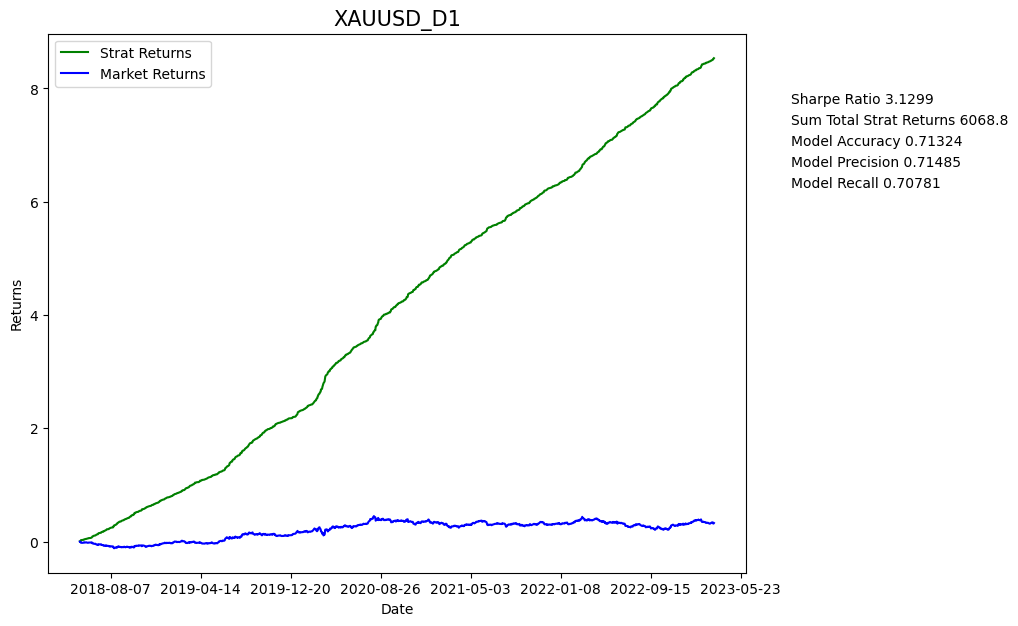

In [25]:

fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(data[-prediction_length:].index.values,
            data['Total Strat Returns'][-prediction_length:].values, color='g', label="Strat Returns")

ax.plot(data[-prediction_length:].index.values,
            data['Market Returns'][-prediction_length:].values, color='b', label="Market Returns")

ax.set(xlabel="Date", ylabel="Returns")
plt.title('XAUUSD_D1', fontsize=15)
ax.xaxis.set_major_locator(ticker.AutoLocator())

plt.figtext(.95, 0.78, s="Sharpe Ratio " +
                '{0:.5g}'.format(Sharpe_Ratio))
plt.figtext(.95, 0.75, s="Sum Total Strat Returns " +
                '{0:.5g}'.format(data['Total Strat Returns'].sum()))
plt.figtext(.95, 0.72, s="Model Accuracy " +
                '{0:.5g}'.format(Accuracy))
plt.figtext(.95, 0.69, s="Model Precision " +
                '{0:.5g}'.format(Precision))
plt.figtext(.95, 0.66, s="Model Recall " +
                '{0:.5g}'.format(Recall))

plt.legend(loc='best')
plt.show()

## To save the model

In [27]:
import joblib

# Save the model to a file named 'svm_model.pkl'
joblib.dump(model, 'svm_model.pkl')

['svm_model.pkl']

## To load the model

In [ ]:
import joblib

# Load the model from the file 'svm_model.pkl'
loaded_model = joblib.load('svm_model.pkl')

# Use the loaded model for prediction or further processing
# The variable 'loaded_model' will contain the loaded SVM model